# Research topics - top N articles distribution

In this notebook, we will check the distribution of top N articles of each research topic to see if we can aggregate them together to compare embedding vectors or we have to compare each article to top N articles of each research topic and determine the topic based on k-NN classification.

### Brief overview

It seems that our top N articles are quite sparse and while we see some shades of clusters, the distinction between research topic is not sufficiently clear. To this purpose, we will adapt article research topic derivation to compare each article to top N articles of each research topic and determine the topic based on k-NN classification.

### Imports & Global Variables

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from box import Box
from google.cloud import bigquery
from sklearn.manifold import TSNE

In [3]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
client = bigquery.Client(project=config.GCP.PROJECT_ID)
# Set the BigQuery dataset schemab
schema = config.GCP.ANALYTICS_SCHEMA
# Set numpy random seed
np.random.seed(config.RANDOM_SEED)

###  Query research topic top N article embeddings

In [8]:
query = f"""
SELECT RESEARCH_AREA_CODE,
       DOI,
       EMBEDDING_TENSOR_SHAPE,
       EMBEDDING_TENSOR_DATA
FROM {schema}.TEXT_EMBEDDING_RESEARCH_AREA_TOP_N_ARTICLES
"""

df = client.query(query).result().to_dataframe()
df.head(50)

,RESEARCH_AREA_CODE,DOI,EMBEDDING_TENSOR_SHAPE,EMBEDDING_TENSOR_DATA
0,B100,"""10.1007/s40656-022-00483-1""",[768],"[-0.0381634347140789, 0.07394112646579742, 0.0..."
1,B100,"""10.30884/seh/2023.02.07""",[768],"[-0.04941747710108757, 0.06325902044773102, 0...."
2,B100,"""10.1002/ece3.7833""",[768],"[-0.047576092183589935, 0.07250853627920151, -..."
3,B100,"""10.4148/jhap.v2i2.1947""",[768],"[-0.03577921539545059, 0.04991002753376961, -0..."
4,B100,"""10.1086/286982""",[768],"[-0.08387969434261322, 0.07964597642421722, -0..."
5,B100,"""10.21638/spbu34.2021.108""",[768],"[-0.05237630382180214, 0.06407561898231506, -0..."
6,B100,"""10.37547/ijlc/volume03issue01-10""",[768],"[-0.05165458843111992, 0.0347670279443264, 0.0..."
7,B100,"""10.1007/s40656-022-00534-7""",[768],"[-0.0641317144036293, 0.06671126931905746, -0...."
8,B100,"""10.1007/s40656-021-00476-6""",[768],"[-0.07441700994968414, 0.06933573633432388, -0..."
9,B100,"""10.1101/023598""",[768],"[-0.039338983595371246, 0.05203067511320114, 0..."


### T-SNE distribution of embeddings

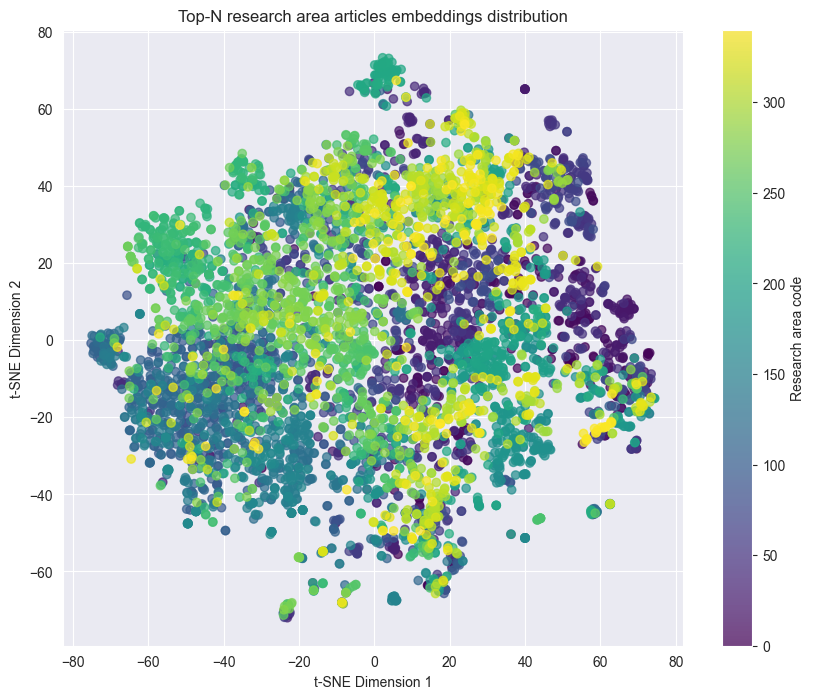

In [11]:
# Preprocess the data
# Ensure EMBEDDING_TENSOR_DATA is in the correct format, assuming it's a list of strings representing numbers
def parse_embedding(data):
    if isinstance(data, str):
        return np.fromstring(data.strip('[]'), sep=',')
    return data

df['EMBEDDING_TENSOR_DATA'] = df['EMBEDDING_TENSOR_DATA'].apply(parse_embedding)

# Ensure that all embeddings are of the same length
embedding_lengths = df['EMBEDDING_TENSOR_DATA'].apply(len)
if embedding_lengths.nunique() != 1:
    raise ValueError("Embeddings are not of the same length")

# Stack embeddings into a matrix
embeddings_matrix = np.stack(df['EMBEDDING_TENSOR_DATA'].values)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings_matrix)

# Add t-SNE results to the dataframe
df['TSNE_DIM_1'] = tsne_results[:, 0]
df['TSNE_DIM_2'] = tsne_results[:, 1]

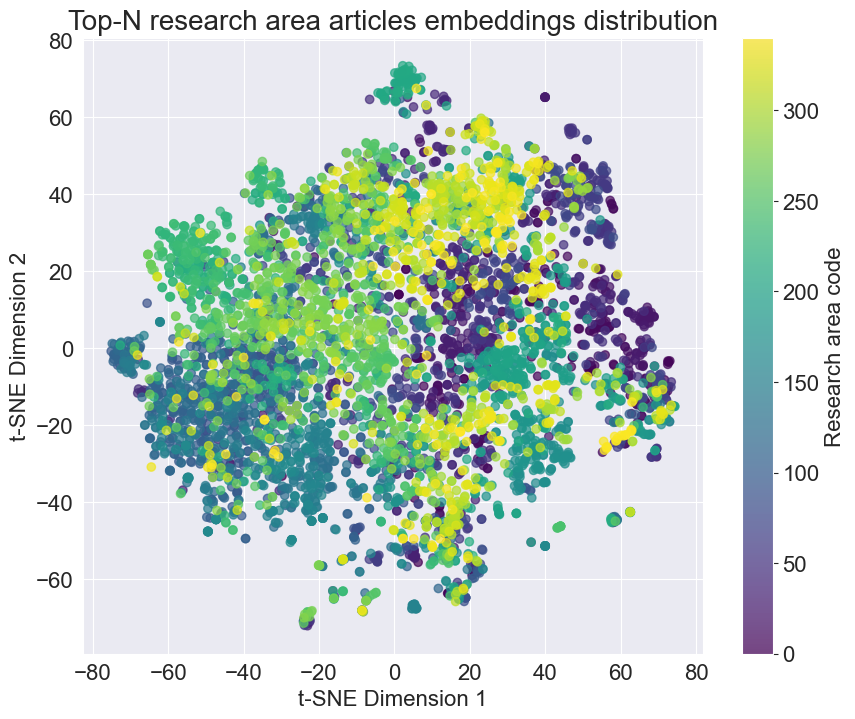

In [21]:

plt.rcParams.update({
    'font.size': 16,  # Global font size
    'axes.titlesize': 20,  # Title font size
    'axes.labelsize': 16,  # X and Y label font size
    'xtick.labelsize': 16,  # X tick label font size
    'ytick.labelsize': 16,  # Y tick label font size
    'legend.fontsize': 16,  # Legend font size
    'figure.titlesize': 20  # Figure title font size
})

# Plot the results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df['TSNE_DIM_1'], df['TSNE_DIM_2'], c=df['RESEARCH_AREA_CODE'].astype('category').cat.codes, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Research area code')
plt.title('Top-N research area articles embeddings distribution')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.savefig('../assets/report_figures/tsne_top_n_articles.png')
plt.show()